In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import plotly
import netCDF4
from datetime import datetime
from matplotlib.cm import get_cmap
import re

LATITUDE_ORIGIN = 63.4269097
LONGITUDE_ORIGIN = 10.3969375
CIRCUMFERENCE = 40075000 # [m], circumference
circumference = CIRCUMFERENCE
def latlon2xy(lat, lon, lat_origin, lon_origin):
    x = np.deg2rad((lat - lat_origin)) / 2 / np.pi * CIRCUMFERENCE
    y = np.deg2rad((lon - lon_origin)) / 2 / np.pi * CIRCUMFERENCE * np.cos(np.deg2rad(lat))
    return x, y

file = "/Users/yaolin/Library/CloudStorage/OneDrive-NTNU/MASCOT_PhD/Data/Nidelva/SINMOD_DATA/samples_2022.05.11.nc"
figpath = "/Users/yaolin/HomeOffice/GOOGLE/Experiments/20220510/fig/"
# file = "/Users/yaolin/OneDrive - NTNU/MASCOT_PhD/Data/Nidelva/SINMOD_DATA/samples_2022.05.10.nc"
# figpath = "/Users/yaolin/HomeOffice/GOOGLE/Experiments/20220509/fig/"


In [2]:
sinmod = netCDF4.Dataset(file)

In [3]:
ind_before = re.search("samples_", file)
ind_after = re.search(".nc", file)
date_string = file[ind_before.end():ind_after.start()]
ref_timestamp = datetime.strptime(date_string, "%Y.%m.%d").timestamp()
timestamp = np.array(sinmod["time"]) * 24 * 3600 + ref_timestamp #change ref timestamp
lat_sinmod = np.array(sinmod['gridLats'])
lon_sinmod = np.array(sinmod['gridLons'])
depth_sinmod = np.array(sinmod['zc'])
salinity_sinmod = np.array(sinmod['salinity'])


In [4]:
for i in range(salinity_sinmod.shape[0]):
    print(i)
    plt.figure(figsize=(12, 10))
    plt.scatter(lon_sinmod, lat_sinmod, c=salinity_sinmod[i, 0, :, :], cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
    plt.xlabel("Lon [deg]")
    plt.ylabel("Lat [deg]")
    plt.title("SINMOD Surface Salinity Estimation on " + datetime.fromtimestamp(timestamp[i]).strftime("%H:%M:%S"))
    plt.colorbar()
    plt.savefig(figpath+"P_{:03d}.jpg".format(i))
    plt.close("all")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [7]:
# load AUV
import pandas as pd
datapath = ''
# sal = pd.read_csv("Salinity.csv")
# est = pd.read_csv("EstimatedState.csv")
# depth = pd.read_csv("Depth.csv")


#% Data extraction from the raw data
# rawTemp = pd.read_csv(datapath + "Temperature.csv", delimiter=', ', header=0, engine='python')
rawLoc = pd.read_csv(datapath + "EstimatedState.csv", delimiter=', ', header=0, engine='python')
rawSal = pd.read_csv(datapath + "Salinity.csv", delimiter=', ', header=0, engine='python')
rawDepth = pd.read_csv(datapath + "Depth.csv", delimiter=', ', header=0, engine='python')

# To group all the time stamp together, since only second accuracy matters
rawSal.iloc[:, 0] = np.ceil(rawSal.iloc[:, 0])
# rawTemp.iloc[:, 0] = np.ceil(rawTemp.iloc[:, 0])
# rawCTDTemp = rawTemp[rawTemp.iloc[:, 2] == 'SmartX']
rawLoc.iloc[:, 0] = np.ceil(rawLoc.iloc[:, 0])
rawDepth.iloc[:, 0] = np.ceil(rawDepth.iloc[:, 0])
rawDepth.iloc[:, 0] = np.ceil(rawDepth.iloc[:, 0])

depth_ctd = rawDepth[rawDepth.iloc[:, 2] == 'SmartX']["value (m)"].groupby(rawDepth["timestamp (seconds since 01/01/1970)"]).mean()
depth_dvl = rawDepth[rawDepth.iloc[:, 2] == 'DVL']["value (m)"].groupby(rawDepth["timestamp (seconds since 01/01/1970)"]).mean()
depth_est = rawLoc["depth (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()

# indices used to extract data
lat_origin = rawLoc["lat (rad)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
lon_origin = rawLoc["lon (rad)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
x_loc = rawLoc["x (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
y_loc = rawLoc["y (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
z_loc = rawLoc["z (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
depth = rawLoc["depth (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
time_loc = rawLoc["timestamp (seconds since 01/01/1970)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
time_sal= rawSal["timestamp (seconds since 01/01/1970)"].groupby(rawSal["timestamp (seconds since 01/01/1970)"]).mean()
# time_temp = rawCTDTemp["timestamp (seconds since 01/01/1970)"].groupby(rawCTDTemp["timestamp (seconds since 01/01/1970)"]).mean()
dataSal = rawSal["value (psu)"].groupby(rawSal["timestamp (seconds since 01/01/1970)"]).mean()
# dataTemp = rawCTDTemp.iloc[:, -1].groupby(rawCTDTemp["timestamp"]).mean()

#% Rearrange data according to their timestamp
data = []
time_mission = []
xauv = []
yauv = []
zauv = []
dauv = []
sal_auv = []
temp_auv = []
lat_auv = []
lon_auv = []

for i in range(len(time_loc)):
#     if np.any(time_sal.isin([time_loc.iloc[i]])) and np.any(time_temp.isin([time_loc.iloc[i]])):
    if np.any(time_sal.isin([time_loc.iloc[i]])):
        time_mission.append(time_loc.iloc[i])
        xauv.append(x_loc.iloc[i])
        yauv.append(y_loc.iloc[i])
        zauv.append(z_loc.iloc[i])
        dauv.append(depth.iloc[i])
        lat_temp = np.rad2deg(lat_origin.iloc[i]) + np.rad2deg(x_loc.iloc[i] * np.pi * 2.0 / circumference)
        lat_auv.append(lat_temp)
        lon_auv.append(np.rad2deg(lon_origin.iloc[i]) + np.rad2deg(y_loc.iloc[i] * np.pi * 2.0 / (circumference * np.cos(np.deg2rad(lat_temp)))))
        sal_auv.append(dataSal[time_sal.isin([time_loc.iloc[i]])].iloc[0])
#         temp_auv.append(dataTemp[time_temp.isin([time_loc.iloc[i]])].iloc[0])
    else:
        print(datetime.fromtimestamp(time_loc.iloc[i]))
        continue

lat4, lon4 = 63.446905, 10.419426  # right bottom corner
lat_auv = np.array(lat_auv).reshape(-1, 1)
lon_auv = np.array(lon_auv).reshape(-1, 1)
Dx = np.deg2rad(lat_auv - lat4) / 2 / np.pi * circumference
Dy = np.deg2rad(lon_auv - lon4) / 2 / np.pi * circumference * np.cos(np.deg2rad(lat_auv))

xauv = np.array(xauv).reshape(-1, 1)
yauv = np.array(yauv).reshape(-1, 1)

alpha = np.deg2rad(60)
Rc = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
TT = (Rc @ np.hstack((Dx, Dy)).T).T
xauv_new = TT[:, 0].reshape(-1, 1)
yauv_new = TT[:, 1].reshape(-1, 1)

zauv = np.array(zauv).reshape(-1, 1)
dauv = np.array(dauv).reshape(-1, 1)
sal_auv = np.array(sal_auv).reshape(-1, 1)
# temp_auv = np.array(temp_auv).reshape(-1, 1)
time_mission = np.array(time_mission).reshape(-1, 1)

# datasheet = np.hstack((time_mission, lat_auv, lon_auv, xauv, yauv, zauv, dauv, sal_auv, temp_auv))

2022-05-09 14:57:07
2022-05-09 15:06:32


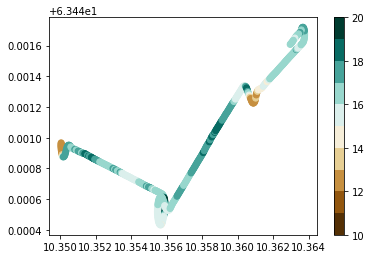

In [6]:
plt.scatter(lon_auv, lat_auv, c=sal_auv, cmap=get_cmap("BrBG", 10), vmin=10, vmax=20)
plt.colorbar()


In [9]:
from DataHandler.SINMOD import SINMOD

ModuleNotFoundError: No module named '_tkinter'

/bin/bash: pip: command not found
